# Quickstart tutorial: Deformation inversion layer

Let us start by creating an invertible random deformation which we can later invert using *deformation inversion layer*.

In [2]:
import torch
from torchvision.transforms import GaussianBlur

from deformation_inversion_layer.interpolator import LinearInterpolator
from deformation_inversion_layer.interpolator.algorithm import \
    generate_voxel_coordinate_grid

In [3]:
def integrate_svf(
    stationary_velocity_field: torch.Tensor,
    squarings: int = 7,
    padding_mode: str = "border",
) -> torch.Tensor:
    """Integrate stationary velocity field in voxel coordinates
    
    Args:
        stationary_velocity_field: Velocity field to integrate with shape
            (batch_size, n_dims, dim_1, ..., dim_{n_dims})
        squarings: Number of scalings and squarings
        padding_mode: Extrapolation mode
    
    Returns:
        Integrated velocity field
    """
    grid = generate_voxel_coordinate_grid(
        shape=stationary_velocity_field.shape[2:],
        device=stationary_velocity_field.device,
        dtype=stationary_velocity_field.dtype,
    )
    integrated = stationary_velocity_field / 2**squarings
    interpolator = LinearInterpolator(padding_mode=padding_mode)
    for _ in range(squarings):
        integrated = (
            interpolator(volume=integrated, coordinates=integrated + grid)
            + integrated
        )
    return integrated

In [4]:
DEFORMATION_SHAPE = (128, 128)

generator = torch.Generator().manual_seed(42)
white_noise = (2 * torch.rand(1, len(DEFORMATION_SHAPE), *DEFORMATION_SHAPE, generator=generator) - 1) * 90
smoothed_noise = GaussianBlur(kernel_size=21, sigma=7)(white_noise)
random_deformation = integrate_svf(smoothed_noise).requires_grad_(True)

Let us visualize the random deformation.

In [5]:
import matplotlib.pyplot as plt

In [6]:
def visualize_deformation_2d(deformation: torch.Tensor, n_rows: int, n_cols: int, **plot_kwargs) -> None:
    """Visualizes combined deformation field as deformed grid

    Args:
        deformation: Tensor with shape (2, dim_1, dim_2)
        n_rows: Number of rows
        n_cols: Number of columns
        **plot_kwargs: Keyword arguments for matplotlib plot function
    """
    device = deformation.device
    rows, cols = torch.meshgrid(
        torch.linspace(0, deformation.size(1) - 1, n_rows, device=device),
        torch.linspace(0, deformation.size(2) - 1, n_cols, device=device),
        indexing='ij'
    )
    grid = torch.stack([rows, cols], dim=0)
    transformed_grid = (
        LinearInterpolator()(volume=deformation[None], coordinates=grid[None]) + grid
    )[0].detach().cpu()
    for row_index in range(transformed_grid.size(1)):
        plt.plot(
            transformed_grid[1, row_index, :],
            transformed_grid[0, row_index, :],
            **plot_kwargs)
    for col_index in range(transformed_grid.size(2)):
        plt.plot(
            transformed_grid[1, :, col_index],
            transformed_grid[0, :, col_index],
            **plot_kwargs)

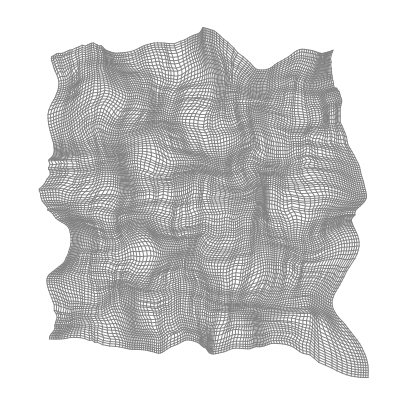

In [7]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.axis('equal')
visualize_deformation_2d(random_deformation[0], 128, 128, color='gray', linewidth=0.7)

Now let us invert the deformation using deformation inversion layer.

In [8]:
from deformation_inversion_layer import fixed_point_invert_deformation

In [9]:
inverted_random_deformation = fixed_point_invert_deformation(random_deformation)

For testing the quality of the generated inverse, let us compose the inverted deformation with the original deformation.

In [10]:
def compose_deformations(left_deformation: torch.Tensor, right_deformation: torch.Tensor) -> torch.Tensor:
    """Compose two deformations represented as voxel coordinate displacement fields
    
    Shape of the inputs should be (batch_size, n_dims, dim_1, ...., dim_{n_dims})

    Args:
        left_deformation: Left side of the composition with shape
            (batch_size, n_dims, dim_1, ...., dim_{n_dims})
        right_deformation: Right side of the composition with shape
            (batch_size, n_dims, *target_shape)

    Returns:
        Composed deformation with shape (batch_size, n_dims, *target_shape)
    """
    coordinate_grid = generate_voxel_coordinate_grid(
        shape=DEFORMATION_SHAPE,
        device=random_deformation.device,
        dtype=random_deformation.dtype
    )
    return LinearInterpolator()(
        volume=left_deformation,
        coordinates=right_deformation + coordinate_grid
    ) + inverted_random_deformation

In [11]:
composition = compose_deformations(random_deformation, inverted_random_deformation)

Now we can visualize the original deformation, the inverted deformation, and the composition of the two.

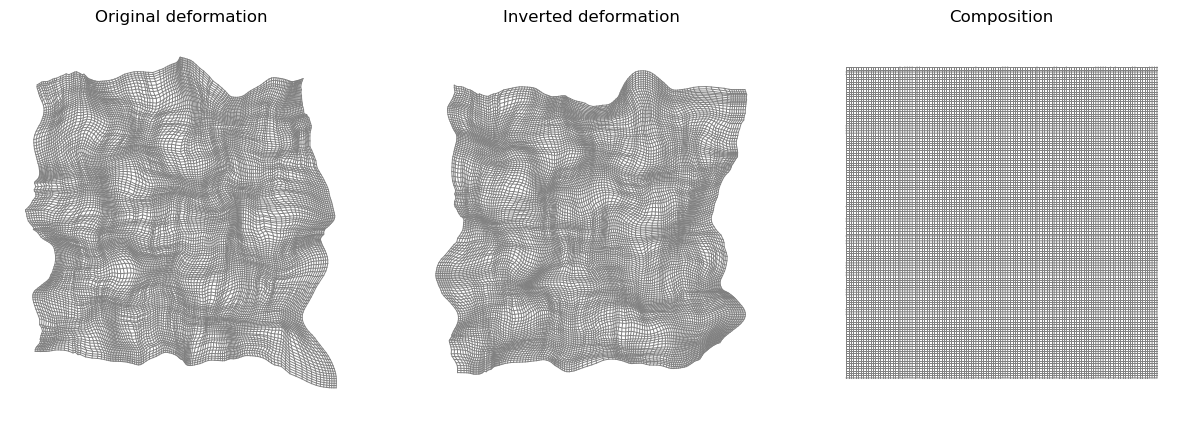

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original deformation')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(random_deformation[0], 128, 128, color='gray', linewidth=0.7)
plt.subplot(1, 3, 2)
plt.title('Inverted deformation')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(inverted_random_deformation[0], 128, 128, color='gray', linewidth=0.7)
plt.subplot(1, 3, 3)
plt.title('Composition')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(composition[0], 128, 128, color='gray', linewidth=0.7)

As can be seen, the composition of the original deformation and the inverted deformation is the identity deformation.

One can also calculate gradients with respect to the inversion operation.

In [13]:
torch.set_printoptions(edgeitems=1)

def dummy_loss(tensor: torch.Tensor) -> torch.Tensor:
    return tensor.mean()

print(f"Gradients of the orignal deformation are None before the backward pass: {random_deformation.grad}")
loss = dummy_loss(inverted_random_deformation)
loss.backward()
print(f"Gradients propagated to the orignal deformation after the backward pass:\n{random_deformation.grad}")

Gradients of the orignal deformation are None before the backward pass: None
Gradients propagated to the orignal deformation after the backward pass:
tensor([[[[ 0.0000e+00,  ...,  0.0000e+00],
          ...,
          [ 0.0000e+00,  ..., -7.4808e-05]],

         [[ 0.0000e+00,  ...,  0.0000e+00],
          ...,
          [ 0.0000e+00,  ..., -1.2921e-04]]]])


Details of the fixed point iteration can also be specified, e.g., allowing larger error. For demonstration purposes, let us increase the error threshold for stopping the iteration to a quite large value.

In [14]:
from deformation_inversion_layer import DeformationInversionArguments
from deformation_inversion_layer.fixed_point_iteration import (
    AndersonSolver, AndersonSolverArguments, MaxElementWiseAbsStopCriterion,
    RelativeL2ErrorStopCriterion)

In [15]:
inversion_arguments = DeformationInversionArguments(
    interpolator=LinearInterpolator(padding_mode='border'),
    forward_solver=AndersonSolver(
        stop_criterion=MaxElementWiseAbsStopCriterion(
            min_iterations=2,
            max_iterations=50,
            threshold=3.0, # We increase the error threshold for stopping the iteration, default is 0.01
        ),
        arguments=AndersonSolverArguments(
            memory_length=4,
            beta=1,
            matrix_epsilon=0.0001,
        )
    ),
    backward_solver=AndersonSolver(
        stop_criterion=RelativeL2ErrorStopCriterion(
            min_iterations=2,
            max_iterations=15,
            threshold=1e-2,
        ),
        arguments=AndersonSolverArguments(
            memory_length=4,
            beta=1,
            matrix_epsilon=0.0001,
        )
    ),
)
less_accurately_inverted_deformation = fixed_point_invert_deformation(
    random_deformation,
    arguments=inversion_arguments
)
composition_with_less_accurate_inverse = compose_deformations(random_deformation, less_accurately_inverted_deformation)

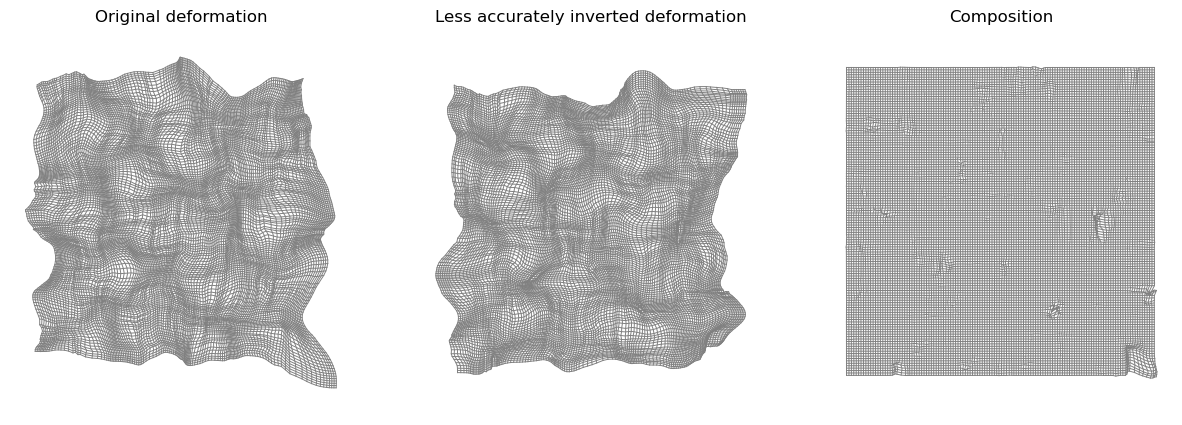

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original deformation')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(random_deformation[0], 128, 128, color='gray', linewidth=0.7)
plt.subplot(1, 3, 2)
plt.title('Less accurately inverted deformation')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(less_accurately_inverted_deformation[0], 128, 128, color='gray', linewidth=0.7)
plt.subplot(1, 3, 3)
plt.title('Composition')
plt.axis('equal')
plt.axis('off')
visualize_deformation_2d(composition_with_less_accurate_inverse[0], 128, 128, color='gray', linewidth=0.7)

As can be seen, the composition is no longer accurate identity deformation.